# learning outcomes
- Method to quantize / measure the image segmentation model: Intersection Over Union (IOU)
- Image gradients associate closely with edges, Edge detections
    * Sobel
    * Scharr (ksize=-1)
    * Laplacian
    * Canny
- Contour detection (`cv.findContour()`)
- Contour features (bounding box, perimeter, area, centroid) as well as properties (aspect ratio, circularity, solidity and extent)
- Build-in methods for block detection
    - Blob is aconnected component in an image with similar brigthness or intensity value
    

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [2]:
!pip install requests


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## IOU
0.55
Formula:
$$IOU = \frac{|A \cap B|}{|A \cup B|}$$

In [3]:
## function to compute IOU
def computeIOU(boxA, boxB):
    """Args:
    boxA: ground truth
    boxB: prediction They are lists of points"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    # compute the intersection area
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    # area of boxA and boxB
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [4]:
img = cv.imread("images/lena.jfif")

In [5]:
boxes = cv.selectROIs("bounding box", img, showCrosshair  = False)
cv.waitKey(0)
cv.destroyAllWindows()

In [6]:
boxes

array([[ 85,  70,  70, 107],
       [171, 101,  38,  83],
       [171, 101,  38,  83]])

In [7]:
def convert_xywh_to_xyxy(box):
    return[box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [8]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]),  (gt[2], gt[3]), (0,0,255), 2)
cv.rectangle(img_copy, (pred[0], pred[1]),  (pred[2], pred[3]), (255,0,0), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25), cv.FONT_HERSHEY_PLAIN, 0.5, (0,255,0), 1)

show_img("IOU", img_copy)

## Image gradients
kernel for $3 \times 3$ Sobel operators:

Vertical direction gradient (x-gradient)
$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

### Pitfalls (bit depth)

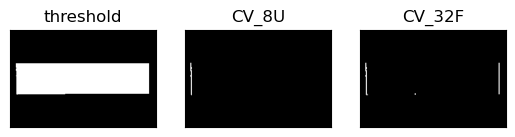

In [9]:
img = cv.imread("images/wood_planck.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# apply sobel kernel (wrong way)
sobely_8u = cv.Sobel(th, cv.CV_8U, 1, 0, ksize=3)

# right way
sobely_32f = cv.Sobel(th, cv.CV_32F, 1, 0, ksize=3)
sobely = cv.convertScaleAbs(sobely_32f)

plt.subplot(131), plt_img(th, "threshold")
plt.subplot(132), plt_img(sobely_8u, "CV_8U")
plt.subplot(133), plt_img(sobely, "CV_32F")
plt.show()

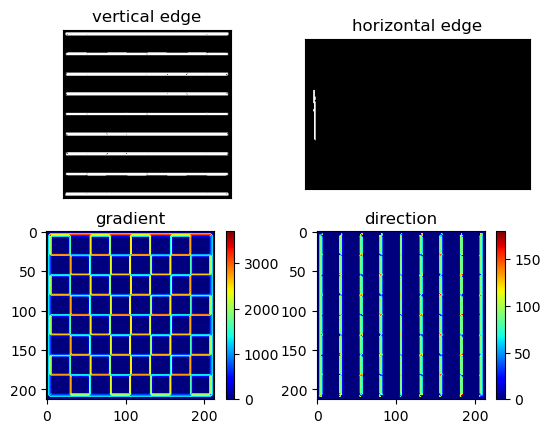

In [10]:
#  combine both the x and y direction to form gradient and orientation map
img = cv.imread("images/chessboard.png", 0)

# sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=-1)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=-1)
sobelx_8u = cv.convertScaleAbs(sobely)

# combine x and y
gradient = cv.magnitude(sobelx, sobely)
direction = np.arctan2(sobelx, sobely) * (180 / np.pi) % 180

plt.subplot(221), plt_img(sobelx_8u, "vertical edge")
plt.subplot(222), plt_img(sobely_8u, "horizontal edge")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient"), plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction"), plt.colorbar()

plt.show()

## Laplacian (second order derivatives)

zero crossing (locate edge)

In [11]:
img = cv.imread("images/lena.jfif", 0)

#blur
blur = cv.GaussianBlur(img, (5, 5), 0)
LoG = cv.Laplacian(blur, cv.CV_16S)
LoG = cv.convertScaleAbs(LoG)

cv.imshow("grayscals", img)
show_img("LoG", LoG)

## Canny edge detector
- lower the number of false positives, enhance the edge detection accuracy.
- Flexible

### Canny algorithm
 - Gaussian bluring (5*5)
 - Sobel x and y (gradient)
 - Non-max suppression
 - Hysteris threshold (best practice: th2/th1 = 2~5)

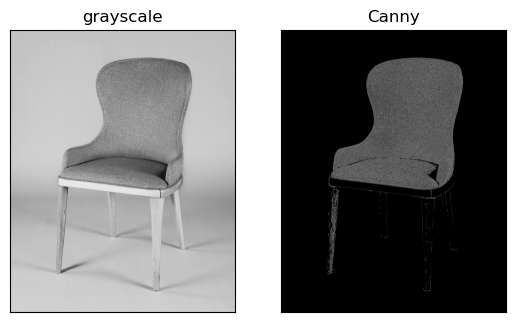

In [12]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

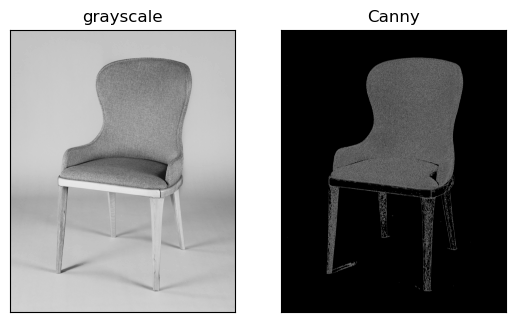

In [13]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

## Exercise
Create a trackbar that control the hysterisis thresholds and display the resulting images from the changes in the thresholds.

In [14]:
img = cv.imread("images/clock.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

wn = "Canny edge"
tracbarName = "low threshold"
ratio = 2.5
img_copy = img.copy()
ksize = 3

def CannyThresh(val):
    edge = cv.Canny(gray, val, ratio * val, apertureSize=ksize)
    # create color edge
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(tracbarName, wn, 0, 100, CannyThresh)

cv.waitKey(0)
cv.destroyAllWindows()

In [15]:
# automatic Canny
def canny_auto(img, method, sigma=0.33):
    """Args:
    img: grayscale
    method: median, triangle and otsu
    sigma=0.33 (default)"""
    if method == "median":
        Th = np.median(img)
        
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    else:
        raise Exception("method specified not available!")
        
    lowThres = (1-sigma) * Th
    highThres = (1+sigma) * Th
    
    return cv.Canny(img, lowThres, highThres)

### Contours
Curve joining all the point along the object boundary

In [16]:
rect = np.zeros((256, 256), dtype=np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


In [17]:
len(contours)

1

In [18]:
contours[0]

array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32)

In [19]:
rect_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)
cv.drawContours(rect, contours, -1, (0, 255, 0), 2)

show_img("contour", rect_bgr)

In [20]:
img = cv.imread("images/monitor.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Binary Threshold
th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# find contour
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#draw contour
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0,255,0), 1)

show_img("contours", img_copy)

In [21]:
len(contours)

12

In [22]:
# one of the simple way: retain just the contour with larger number of point
length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_copy = img.copy()
cv.drawContours(img_copy, [cnt], -1, (0,255,0), 1)

show_img("contours", img_copy)

## Contour features
- centroid
- area
- perimeter
- bounding box

In [23]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [24]:
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

print(f"The centroid of contour: {(cx, cy)}")

The centroid of contour: (105, 103)


In [25]:
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)
print(f"The area of contour: {area}")
print("The area of contour: {}".format(round(peri, 3)))

The area of contour: 37113.5
The area of contour: 1056.777


## contour properties
$$aspect \ ratio = \frac{width}{height}$$

$$circularity = \frac{4 \times \pi \times A}{Perimeter^2}$$

In [26]:
img = cv.imread("images/remote-controller.webp")

show_img("aircon", img)

In [27]:
# resize -> grauscale -> bilateral -> Canny -> findContour -> Contour features
# sort the contour with respect to area in descending order

factor = 300 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = canny_auto(blur, method="triangle")

show_img("edge", edge)

In [28]:
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cnts = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None
img_copy = img.copy()
# rectangular contour
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        screen = c
        break

cv.drawContours(img_copy, [screen], -1, (0,255,0), 2)
show_img("contour", img_copy)

In [29]:
# define the low and high threshold for red color in HSV color space
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam is detected!")
    
kernel = np.ones((3, 3), dtype=np.uint8)
fixed_width = min_area = 500
factor = fixed_width / cap.get(3)  # frame width

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("frame not received")
        break
        
    # resize -> blur -> change to HSV  -> color inRange -> morphology
    resize = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resize, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    # color inRange
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    
    # morphology opening (remive noise)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    
    # find contour
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = contours[0]
    bbs = []
    
    # filter out the smaller object and draw bounding box
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
            
    for bb in bbs:
        x, y, w, h = bb
        cv.rectangle(resize, (x, y), (x+w, y+h), (0,255,0), 2)
        
    cv.imshow("red object", resize)
    k = cv.waitKey(1) & 0xFF

    if k==27:
        break
        
cv.destroyAllWindows()
cap.release()

## Weekly activity

1. Experiment with different edge detectors: Sobel, Laplacian, Prewitt, Scharr derivatives and Canny operators (all with aperture size of 3) on image named 'pineapple.jfif'. Comment on the results.

(<Axes: title={'center': 'Canny'}>, None)

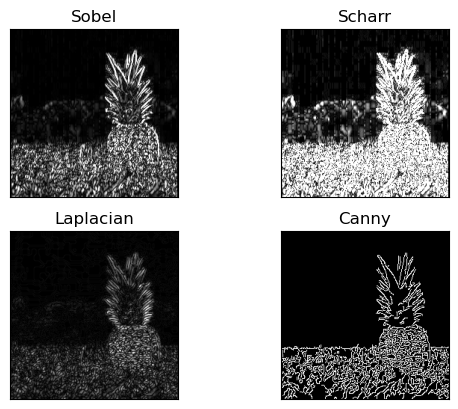

In [30]:
img = cv.imread("images/pineapple.jfif", 0)

# sobel
sobely_32f = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=3)
sobely = cv.convertScaleAbs(sobely_32f)

# scharr
scharr_32f = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=-1)
scharr = cv.convertScaleAbs(scharr_32f)

# laplacian
blur = cv.GaussianBlur(img, (5, 5), 0)
LoG = cv.Laplacian(blur, cv.CV_16S)
LoG = cv.convertScaleAbs(LoG)

# Canny
edge = cv.Canny(img, 100, 300)

plt.subplot(221), plt_img(sobely, "Sobel")
plt.subplot(222), plt_img(scharr, "Scharr")
plt.subplot(223), plt_img(LoG, "Laplacian")
plt.subplot(224), plt_img(edge, "Canny")

2. Write a program to identify the white object (probably laptop) present in the image 'electronic.jfif'. Draw bounding boxes on the objects.

(<Axes: title={'center': 'Bounding box'}>, None)

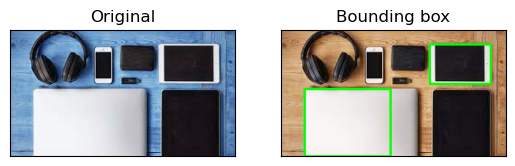

In [31]:
img = cv.imread("images/electronic.jfif")
img_copy = img.copy()
gray = cv.cvtColor(img_copy, cv.COLOR_BGR2GRAY)

# Apply thresholding to isolate white regions
_, thresholded = cv.threshold(gray, 220, 255, cv.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes around white objects
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    if w > 30 and h > 30:  # Filtering out small noise
        cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green bounding box
        
img_copy = cv.cvtColor(img_copy, cv.COLOR_BGR2RGB)

plt.subplot(121), plt_img(img, "Original")
plt.subplot(122), plt_img(img_copy, "Bounding box")

3. Isolate the clock with the aid of edge detection and contours' properties. The example result should be as follows:
<img src="image_embed/clock_segmented.jpg" alt="Segmented_clock" />

(<Axes: title={'center': 'contour'}>, None)

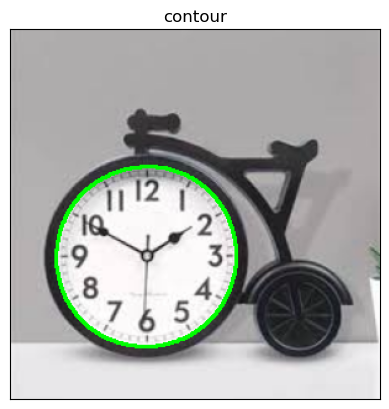

In [33]:
img = cv.imread("images/clock.jpg")

# resize
factor = 300 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# blur & canny edge
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = canny_auto(blur, method="triangle")

contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cnts = sorted(contours, key=cv.contourArea, reverse=True)[:5]
clock = None
img_copy = img.copy()
# rectangular contour
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        clock = c
        break

cv.drawContours(img_copy, [clock], -1, (0,255,0), 2)

plt.subplot(111), plt_img(img_copy, "contour")